## Interactive lab experiment parameterization widget
April 5, 2025

This widget was developed to help narrow the parameter space--namely wrt bathymetry (bottom slope), water level, and the bichromatic waves (amplitude and frequency)--for the lab experiments by the SEDCOLAB SS-IG team.

Please note this is a simplified analytical model that with limited exceptions models only the short waves (i.e., not long waves).

Planned (maybe) future improvements include:
* (organizational) Compare the functions in this file to those in Christine's stone_lab_fns.py file; create a separate file with additional functions from this notebook as needed.
* (scientific) Plots in the widget that rely on temporally varying variables generally use their maximum values. However, the max values are not necessarily temporally coincident. This choice could be explored via sensitivity analysis or corrected to be temporally consistent across parameters.

Most of the functions in this notebook came from or are lightly adapted from lab_scaling.ipynb. Please see that file for more detailed preamble/explanation.

In [25]:
import netCDF4 as nc4
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib 
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import HBox, VBox
from IPython.display import display
from datetime import datetime, timedelta, date
import warnings
import math
from functools import partial # so that we cna pass arguments to callbacks


Using matplotlib backend: module://matplotlib_inline.backend_inline


## Wave functions

In [26]:
# Dispersion relation

def dispersi(const):
    """
    Solve the linear dispersion relationship for surface gravity waves.

    Input:
        const = omega^2 * h / g, where:
            omega = radian frequency,
            h = water depth,
            g = acceleration due to gravity.
    Output:
        kh = wavenumber times water depth.
    Notes: Solves omega^2 * h / g = kh * tanh(kh) using Newton-Raphson iteration.
    
    Code to compute omega from frequency or period:
          g = 9.81
          omega = 2 * np.pi * f = 2 * np.pi / T
          const = (omega ** 2) * h / g
    Code to compute wavelength from kh:
          k = kh / h
          L = 2 * np.pi / k

    Code modified by C.M.Baker on Oct 2024
    """

    # Convert input to array, ensuring it's at least 1D
    const = np.atleast_1d(const)

    # Set negative values to NaN to avoid sqrt warning, assuming they are invalid
    const = np.where(const < 0, np.nan, const)

    # Initialize kh with zeros where const is zero, else with sqrt(const) as initial guess
    kh = np.where(const == 0, 0, np.sqrt(const))

    # Newton-Raphson iteration
    tolerance = 1e-6
    max_iterations = 100
    for _ in range(max_iterations):
        delta = (kh * np.tanh(kh) - const) / (np.tanh(kh) + kh / np.cosh(kh)**2)
        kh -= delta
        if np.all(np.abs(delta) < tolerance):
            break

    return kh

In [27]:
# Calculate angular freq and wave number from frequency and water depth

def calc_omega_k(f, h):
    """ 
    f = frequency
    h = water depth 
    
    Example usage:
    [omega, k] = calc_omega_k(frequency_value, water_depth_value)
    """
    
    # Constants
    g = 9.81
    
    # Angular frequency calculation
    omega = 2 * np.pi / (f ** (-1))
    
    # Constants calculation
    cons = omega ** 2 * h / g
    
    # Call to dispersi function (assuming it's defined elsewhere)
    kh = dispersi(cons)
    
    # Calculate k
    k = kh / h
    
    return omega, float(k[0])

In [28]:
def waveshoal_h_nonmono(T, H0, theta0, gamma, h):
    """
    Code modified from M.Moulton on April 2, 2023
    
    Nonmonotonic wave shoaling (can shoal and de-shoal - e.g., bathy has bar and dip)
    
    Input:
        T: offshore period
        H0: deep water wave height
        theta0: offshore wave angle relative to beach (amount it's off from being perpendicular to the beach face)
        gamma: breaking index (short wave height to water depth)
        h: water depth
        
    Look at Snell's Law
    """
    
    # Suppress RuntimeWarning
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Constants
    g = 9.81  # m/s^2

    # Calculate wavelengths in deep water at depths h

    # Deep water wavelength:
    Ldeep = g * T**2 / (2 * np.pi)

    # Wavelength, Ole Madsen approx:
    L = Ldeep * (1 - np.exp(-(2 * np.pi * h / Ldeep)**1.25))**0.4
    

    # Calculate group and phase speeds at depths h
    c = L / T  # Phase speed; i.e., wavelength / period
    k = 2 * np.pi / L  # Wavenumber; i.e., radians per unit distance
    cg = (L / (2 * T)) * (1 + 2 * (k) * h / np.sinh(2 * (k) * h))  # Group velocity - notes: L/2T is k; rearranged version of dispersion relation

    # Calculate group and phase speeds at depth h0
    c0 = c[0]  # Phase speed at depth h0    (wave celerity)
    cg0 = cg[0]  # Group speed at depth h0  (wave group velocity)

    # Compute wave height and angle at depths h
    theta = np.arcsin(c / c0 * np.sin(np.radians(theta0)))
    H = H0 * np.sqrt(cg0 / cg) * np.sqrt(np.cos(np.abs(np.radians(theta0))) / np.cos(np.abs(np.radians(theta))))

    # Calculate breaking variables
    breaking_index = np.where(H / h > gamma)[0] # index of vector
    breaking_index = breaking_index[0]
    breaking_depth = h[breaking_index]
    breaking_height = H[breaking_index]
    breaking_angle = np.degrees(theta[breaking_index])

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan
    L[h < 0] = np.nan
    c[h < 0] = np.nan
    cg[h < 0] = np.nan

    # Store variables
    wave = {'h': h,
            'L': L,
            'Ldeep': Ldeep,
            'H': H,
            'c': c,
            'cg': cg,
            'theta': np.degrees(theta),
            'breaking_depth': breaking_depth,
            'breaking_height': breaking_height,
            'breaking_angle': breaking_angle,
            'breaking_index': breaking_index}

    # Compute profile onshore of breaking
    H[breaking_index] = h[breaking_index] * gamma
    binds = np.arange(breaking_index, len(h) - 1)

    for ii in binds:
        if h[ii + 1] < h[ii]:
            # Depth-limited breaking
            H[ii + 1] = h[ii + 1] * gamma
        else:
            # Re-shoaling - if threshold not exceeded
            h_2 = h[ii:]
            H0_2 = H[ii]
            theta0_2 = np.degrees(theta[ii])

            wave_2 = waveshoal_subf(T, H0_2, theta0_2, gamma, h_2)

            H_2 = wave_2['H']
            theta_2 = wave_2['theta']
            breaking_index2 = wave_2['breaking_index']

            # Fill in values
            H[ii:] = H_2
            theta[ii:] = theta_2

            # Second breaking region
            H[ii + breaking_index2:] = h[ii + breaking_index2:] * gamma

            break

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan

    wave['H'] = H
    wave['theta'] = np.degrees(theta)
    
    # AReset the warnings
    warnings.resetwarnings()

    return wave

def waveshoal_subf(T, H0, theta0, gamma, h):
    # subf = subfunction
    # this looks nearly identical shoaling waves up to breakpoint
    
    # Constants
    g = 9.81  # m/s^2

    # Calculate wavelengths in deep water at depths h

    # Deep water wavelength:
    Ldeep = g * T**2 / (2 * np.pi)

    # Wavelength, Ole Madsen approx:
    L = Ldeep * (1 - np.exp(-(2 * np.pi * h / Ldeep)**1.25))**0.4

    # Calculate group and phase speeds at depths h
    c = L / T  # Phase speed
    k = 2 * np.pi / L  # Wavenumber
    cg = (L / (2 * T)) * (1 + 2 * (k) * h / np.sinh(2 * (k) * h))  # Group velocity

    # Calculate group and phase speeds at depth h0
    c0 = c[0]  # Phase speed at depth h0
    cg0 = cg[0]  # Phase speed at depth h0

    # Compute wave height and angle at depths h
    theta = np.arcsin(c / c0 * np.sin(np.radians(theta0)))
    H = H0 * np.sqrt(cg0 / cg) * np.sqrt(np.cos(np.abs(np.radians(theta0))) / np.cos(np.abs(np.radians(theta))))

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan
    L[h < 0] = np.nan
    c[h < 0] = np.nan
    cg[h < 0] = np.nan

    # Calculate breaking variables
    breaking_index = np.where(H / h > gamma)[0]
    breaking_index = breaking_index[0]
    breaking_depth = h[breaking_index]
    breaking_height = H[breaking_index]
    breaking_angle = np.degrees(theta[breaking_index])

    # Store variables
    wave_sub = {'h': h,
                'L': L,
                'Ldeep': Ldeep,
                'H': H,
                'c': c,
                'cg': cg,
                'theta': np.degrees(theta),
                'breaking_depth': breaking_depth,
                'breaking_height': breaking_height,
                'breaking_angle': breaking_angle,
                'breaking_index': breaking_index}

    return wave_sub


In [29]:
# Functions for indexing, unit conversion

def find_closest_index(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

def indices_between(lst, lower_bound, upper_bound):
    between_indices = [i for i, x in enumerate(lst) if lower_bound < x < upper_bound]
    return between_indices

def ft2m(feet):
    meters = feet * 0.3048  # 1 foot is approximately equal to 0.3048 meters
    return meters

In [30]:
# Calculation of bound wave from the short waves (Longuet-Higgins)

def calc_LH_boundwave(a1, a2, f1, f2, h, t):
    rho = 997
    g = 9.81
    
    # Average wave statistics
    T = 2 / (f1 + f2)  # Peak wave period
    omega0, k0 = calc_omega_k((f1 + f2)/2, h)  # Angular frequency and wavenumber of bichromatic waves
    L = 2 * np.pi / k0  # Wavelength
    c = L / T
    
    # statistics of individual waves
    [omega1, k1] = calc_omega_k(f1, h)
    [omega2, k2] = calc_omega_k(f2, h)
    
    # group stats
    omegag = abs(omega1 - omega2)
    kg = abs(k1 - k2)
    fg = abs(f1 - f2)  # Group frequency
    cg = omegag / kg
    Eg = 0.5 * rho * g * ((a1 + a2) * np.cos(0.5 * omegag * t)) ** 2 # energy of group as a fn of time
    Sxx = Eg * (( 2 * cg / c ) - 0.5) # radiation stress of group as a fn of time
    etab = - (1/rho) * Sxx / (g * h - cg**2) # amplitude of bound wave as a fn of time
    ab = - np.min(etab) / 2
    
    return etab, ab

## Constants

In [31]:
# constants
rhos = 2650 # kg/m3, density of sand
rhof = 997 # kg/m3, density of fresh fluid
drho = rhos - rhof # kg/m3, density difference
g = 9.81 # m/s2, gravity
sdense = rhos / rhof # typ 2.65, specific density
sgrav = (rhos - rhof) / rhof # typ 1.65, specific gravity
mu = 0.00139 # kg/m/s, kinematic viscosity
nu = mu / rhof # m2/s, dynamic viscosity
kappa = 0.41 # von Karman's constant

## Givens/test values

Note that many of these are overridden in the widget code cell. They are left here in case they are needed for testing functions.

In [32]:
# define bichromatic wave and water properties
f1 = 0.5 # frequency 
f2 = 0.43 # frequency 
a1 = 0.05 # amplitude  
a2 = 0.05 # amplitude
swl = 1.2 #1.5 # still water level at the wavemaker
theta0 = 0 # wave direction relative to shore-normal
gammab = 0.5 # breaking threshold (H/h)

D50 = 0.15/1000 # m, median sediment size, model = 0.15

## Bathymetry

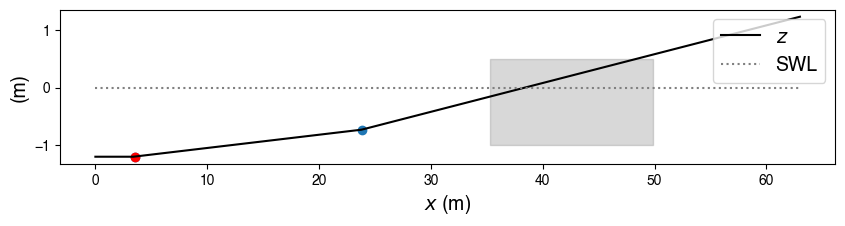

In [33]:
# NOTE: Doing something weird with the (len(i...)+0.5) to make the indices/array sizes weird -- make sure this is ok
# GIVENS: lab domain
lab_slope = 1/20 #1/43.5 #1/32
lab_length = 63
lab_depth = 1.5 + 0.48 #1.2 + 0.48 #1.5+0.48
lab_beach = 1.36 #1.7
isComposite = True

# set up bathymetry based on swl
def create_bathy(swl, lab_slope, lab_length, lab_depth, lab_beach, isComposite):
    dx = 0.1
    x = np.arange(0, lab_length + dx, dx)
    d = np.zeros_like(x)
    ioffbeach = indices_between(x, ft2m(11.11+0.31), ft2m(11.11+0.31+66.7)) # this is a list of indices for the "offshore" 1:43.5 slope
    
    if lab_slope < 1/43.5: # if shallower than 1:43.5, it HAS to be a composite slope bc the "offshore slope" is built in
        #print("composite slope due to shallow slope")
        # create offshore slope
        slope_off = 1/43.5
        off_depth = ft2m(66.7)*slope_off
        d[ioffbeach] =  np.arange(0, off_depth + dx * slope_off, dx * slope_off)[1:]
        # create experiment slope
        iexptslope = np.arange(ioffbeach[-1]+1, len(x)) # list of indices from end of offshore slope to end of tank
        d[iexptslope] = np.arange(d[ioffbeach[-1]] + dx * lab_slope, d[ioffbeach[-1]] + dx * lab_slope * (len(iexptslope)+0.5), dx * lab_slope)
    elif isComposite:
        #print("composite slope due to user input")
        # create offshore slope
        slope_off = 1/43.5
        off_depth = ft2m(66.7)*slope_off
        d[ioffbeach] =  np.arange(0, off_depth + dx * slope_off, dx * slope_off)[1:]
        # create experiment slope
        iexptslope = np.arange(ioffbeach[-1]+1, len(x)) # list of indices from end of offshore slope to end of tank
        d[iexptslope] = np.arange(d[ioffbeach[-1]] + dx * lab_slope, d[ioffbeach[-1]] + dx * lab_slope * (len(iexptslope)+0.5), dx * lab_slope)
    else:
        #print("uniform slope steeper than or equal to 1:43.5")
        ifull = np.arange(ioffbeach[0], len(x), 1)
        d[ioffbeach[0]:] = np.arange(0, lab_slope * dx * (len(ifull)), dx*lab_slope)
    
    #iflat = find_closest_index(d[ioffbeach[-1]+1:ibeach[-1]], d[ioffbeach[-1]])
    #d[ioffbeach[-1]+1:iflat+ioffbeach[-1]] = d[ioffbeach[-1]]
    #d[:ioffbeach[0]] = 0
    
    # define water depth
    h = -(d-swl)
    
    # window
    winloc = ft2m(115.41+0.31+np.array([0, 48]))

    return x, d, h, ioffbeach, winloc

x, d, h, ioffbeach, winloc = create_bathy(swl, lab_slope, lab_length, lab_depth, lab_beach, isComposite)
# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 2))
ax.plot(x, -h, lw=1.5, color='k', label='$z$')
ax.plot(x, np.zeros_like(h), lw=1.5, color='grey', linestyle=':', label='SWL')
ax.scatter([x[ioffbeach[0]], x[ioffbeach[-1]]], [-h[ioffbeach[0]], -h[ioffbeach[-1]]]) # ioffbeach[-1] is the shoreward end of set 1:43.5 slope
ax.scatter([x[ioffbeach[0]]], [-h[ioffbeach[0]]], color='red')
ax.fill_betweenx([-1, 0.5], winloc[0], winloc[1], color='gray', alpha=0.3)
font_size = 14
ax.set_xlabel('$x$ (m)', fontsize=font_size)
ax.set_ylabel('(m)', fontsize=font_size)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
plt.ioff()
plt.show()

In [34]:
### Peakfinder, 2/5/25
# Created the more general findpeaks first, then made a plot (see a few cells down) to verify it works
# Then created findMinH since that's all we are missing in shoalwave
def findpeaks(wstimeseries):
    dz = [wstimeseries[i+1] - wstimeseries[i] for i in range(len(wstimeseries)-1)]
    dz.append(-99) # not really needed but it helps w/ thinking about indices since dz will be one shorter than wstimeseries ("missing" element at right end)
    dz = np.array(dz)
    indices = np.where((dz[:-1] >=0) & (dz[1:] < 0))[0]
    heights = wstimeseries[indices + 1]
    maxHeight = max(heights)
    maxInd = np.where(wstimeseries == maxHeight)[0]
    minHeight = min(heights)
    minInd = np.where(wstimeseries == minHeight)[0]
    return maxHeight, maxInd, minHeight, minInd

def findMinH(wstimeseries):
    dz = [wstimeseries[i+1] - wstimeseries[i] for i in range(len(wstimeseries)-1)]
    dz.append(-99) # not really needed but it helps w/ thinking about indices since dz will be one shorter than wstimeseries ("missing" element at right end)
    dz = np.array(dz)
    indices = np.where((dz[:-1] >=0) & (dz[1:] < 0))[0]
    heights = wstimeseries[indices + 1]
    minHeight = min(heights)
    return minHeight

In [35]:
# Calculate bulk wave statistics

def calc_wave_field(a1, a2, f1, f2, swl):
    # bichromatic wave period and wavelength:
    T = 2 / (f1 + f2)
    Tg = 1 / (f1 - f2)
    [omega, k0] = calc_omega_k(1/T,swl)
    L0 = 2 * np.pi / k0
    
    # max height
    H0 = 2 * (a1 + a2)
    a0 = H0 / 2
    h0 = swl
    
    # calc omega, k
    [omega1, k1] = calc_omega_k(f1,swl)
    [omega2, k2] = calc_omega_k(f2,swl)
    
    # Define the parameters
    xp = 0#np.arange(0, 58.1, 0.1)#200.1, 0.1)
    tp = np.arange(0, 58.1, 0.1)#200.1, 0.1)
    
    # define phase lags
    phi1 = 180
    phi2 = 0
    
    # Define the wave expressions
    eta0 = a1 * np.cos(omega1 * tp - k1 * xp + np.deg2rad(phi1)) + a2 * np.cos(omega2 * tp - k2 * xp + np.deg2rad(phi2))

    Hmin = findMinH(eta0)

    return T, Tg, omega, k0, L0, H0, a0, h0, omega1, k1, omega2, k2, xp, tp, phi1, phi2, eta0, Hmin

a1 = 0.05
a2 = 0.05
f1 = 0.43
f2 = 0.47
swl = 1.3
T, Tg, omega, k0, L0, H0, a0, h0, omega1, k1, omega2, k2, xp, tp, phi1, phi2, eta0, Hmin = calc_wave_field(a1, a2, f1, f2, swl)

0.09973176031323003
0.0024924965005847857


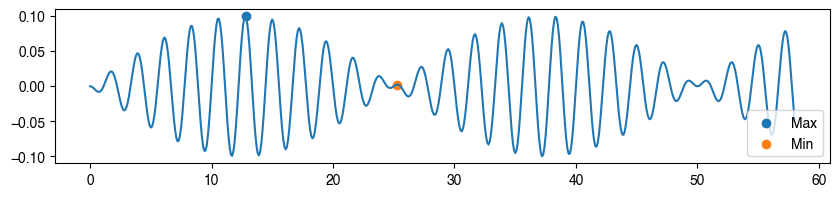

In [36]:
# check that peakfinder works
maxH, maxI, minH, minI = findpeaks(eta0)
print(maxH)
print(minH)
fig, ax = plt.subplots(1, figsize=(10, 2))
ax.plot(tp, eta0)
ax.scatter(tp[maxI], maxH, label='Max')
ax.scatter(tp[minI], minH, label='Min')
ax.legend(loc='lower right')
plt.show()

## Estimate shoaling and runup

In [37]:
# shoal waves to breaking, assuming linear wave theory

def shoal_wave(T, Tg, H0, theta0, gammab, h, eta0, Hmin, H_IG):
    wave =  waveshoal_h_nonmono(T, H0, theta0, gammab, h) # this is MAX WAVE
    wave_IG =  waveshoal_h_nonmono(Tg, H_IG, theta0, gammab, h) # CAUTION: H is hardcoded, needs to be updated
    wave_half =  waveshoal_h_nonmono(T, H0/2, theta0, gammab, h)
    geomscale = H0/1 # more or less 0.05m:1m
    if Hmin < 0.0005:
        print("Using H_min = 0.0005m")
        wave_min = waveshoal_h_nonmono(T, 0.0005, theta0, gammab, h) # this is MIN WAVE HEIGHT
    else:
        wave_min = waveshoal_h_nonmono(T, Hmin, theta0, gammab, h) # this is MIN WAVE HEIGHT

    L = wave['L']
    H = wave['H']
    ib = wave['breaking_index'] + 1 # offset maybe due to the transition between matlab and python?
    hb = wave['breaking_depth'] # water depth at breaking
    #print(hb)
    Hb = wave['breaking_height'] # wave height at breaking
    theta = wave['theta']
    ab = Hb / 2 # amplitude at breaking
    Lb = L[ib] # wavelength at breaking
    thetab = theta[ib] # angle at breaking
    etab = eta0 * (Hb / H0) # as a proxy for the water surface elevation near breaking, increase eta based on shoaling. 
    etab[np.isnan(etab)] = 0
    # NOTE that linear wave theory does NOT hold here and therefore, this does not represent the water surface near breaking accurately.

    return wave, wave_IG, wave_half, wave_min, L, H, ib, hb, Hb, theta, ab, Lb, thetab, etab

In [38]:
# This runup function uses the Stockdon 2006 formulation. It was originally written in lab_scaling.ipynb but was commented out;
# checked against Equation 19 from the paper on Dec. 19, 2024.
def calculate_runup(slope, Hsig, L):
    runup = 1.1 * (0.35 * slope * math.sqrt(Hsig * L) + 0.5 * math.sqrt(Hsig * L) * (0.563 * (slope ** 2) + 0.004))
    return runup

# sample values
# H0 = ?
# L0 = ?
# runup = calculate_runup(cmpst_slope, H0, L0)
# irunup = find_closest_index(d, runup+swl)
#print(runup) 

## Orbital velocities & excursion
at bottom boundary

In [39]:
def wave_orbital_velocity(a, T, L, z, h, theta):
    g = 9.81
    u = a * ((g*T)/L) * ((np.cosh(2*np.pi*(z+h)/L)) / (np.cosh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    w = a * ((g*T)/L) * ((np.sinh(2*np.pi*(z+h)/L)) / (np.cosh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    ao = u / (2 * np.pi / T)
    return u, w, ao

## Sediment mobilization
frictional coefficient (f_w), bed shear stress (tau_{bw}), frictional velocity (u_*)


In [40]:
# Frictional coefficient
def calculate_fw(D50, ab):
    fw = np.exp(5.213 * (2.5 * D50 / ab) ** 0.194 - 5.977)
    return fw

# Bed shear stress
def calculate_taub(rhof, fw, ub):
    taub = (2 / (3 * np.pi)) * rhof * fw * (ub ** 2)
    return taub

# Frictional velocity
def calculate_ustar(tau, rhof):
    ustar = np.sqrt(tau / rhof)
    return ustar

## Hydrodynamic scaling parameters

### Iribarren Number

In [41]:
def calculate_zeta(beta, H, T):
    g = 9.81
    d = 1000
    L0 = T * np.sqrt( g * d )
    zeta = beta / np.sqrt(H / L0)
    # if zeta <= 0.4:
    #     print('Spilling')
    # elif zeta > 0.4 and zeta <= 2:
    #     print('Plunging')
    # elif zeta > 2:
    #     print('Collapsing or surging')
    return zeta

### Ursell number

In [42]:
def calculate_ursell(H, k, h):
    # Calculate Ur
    Ur = (3/8) * H * k / ((k * h) ** 3)
    
    # Calculate B
    B = 0.857 / (1 + math.exp((-0.471 - math.log(Ur) / 0.297)))
    
    # Calculate psi
    psi = -math.pi/2 + (math.pi/2) * math.tanh(0.815 / (Ur ** 0.672))
    
    # Calculate Sk and As
    Sk = B * math.cos(psi)
    As = B * math.sin(psi)
    
    return Ur, Sk, As

## Sediment transport scaling parameters

### Stokes settling velocity 

In [43]:
def calculate_ws(D50, drho, g, mu):
    ws = ((D50 ** 2) * drho * g) / (18 * mu)
    return ws

### Rouse number

In [44]:
def calculate_Rou(ws, kappa, ustar):
    Rou = ws / (kappa * ustar)
    #if Rou <= 0.8:
    #    print('Wash load')
    #elif Rou > 0.8 and Rou <= 1.2:
    #    print('Suspended load (100%)')
    #elif Rou > 1.2 and Rou <= 2.5:
    #    print('Suspended load (50%)')
    #elif Rou > 2.5:
    #    print('Bed load')
    return Rou

### Shields Number

In [45]:
def calculate_shields(taub, rhos, rhof, D50, nu):
    g = 9.81
    shields = taub / ((rhos-rhof) * g * D50)
    Restar = np.sqrt(taub / rhof) * D50 / nu
    return shields, Restar

### Stokes Number 

In [46]:
# stokes fall velocity
# def calculate_stk(D50):
#     stk = 16.17 * D50**2 / ((1.8e-5) + (12.1275 * D50**3)**0.5)
#     return stk

# another stokes? 
def calculate_Stk(rhos, D50, mu, ustar):
    Stk = (rhos * D50 * ustar) / (18 * mu)
    return Stk

# Interactive widget 

Effect of wave conditions on hydrodynamic and sediment transport indicators

Notes:
* "Enforce composite slope" will create a composite slope with the user-specified slope (of any value) landward of the end of CHL's fixed 1:43.5 slope. 
* If this box is not checked and the user-inputted slope is gentler than 1:43.5, the code will force the slope to be composite; if not checked and the user value is steeper than 1:43.5, then the whole slope will be at the user value.
* Do not adjust the sliders with the "save figure to pdf" box checked. Instead, check the box once the parameters are set; after the figure flashes, then uncheck the box.

In [49]:
%matplotlib

def update_plot(a1, a2, f1, f2, swl, slope_h, isComposite,saveFigure):
    ### CALCULATIONS ###

    # wave time series
    t = np.arange(0, 30, 0.1) # timesteps
    wave1 = a1*np.cos(2*np.pi*f1*t) # Christine uses omega*t inside parentheses. Should be the same.
    #wave2 = a2*np.sin(2*np.pi*f2*t+np.pi/2)
    wave2 = a2*np.cos(2*np.pi*f2*t)
    added = wave1 + wave2
    etaIG, aIG = calc_LH_boundwave(a1, a2, f1, f2, swl, t)

    # Hydrodynamics
    x, d, h, ioffbeach, winloc = create_bathy(swl, 1/slope_h, lab_length, lab_depth, lab_beach, isComposite)
    T, Tg, omega, k0, L0, H0, a0, h0, omega1, k1, omega2, k2, xp, tp, phi1, phi2, eta0, Hmin = calc_wave_field(a1, a2, f1, f2, swl)
    wave, wave_IG, wave_half, wave_min, L, H, ib, hb, Hb, theta, ab, Lb, thetab, etab = shoal_wave(T, Tg, H0, theta0, gammab, h, eta0, 0.02, aIG*2)
    
    # Runup
    r2 = calculate_runup(1/slope_h, H0, L0)
    # Sediment transport
    ws = calculate_ws(D50, drho, g, mu) # settling velocity; not dependent on any of the variables that vary through the profile
    # Orbital velocities at wavemaker, bottom boundary
    [ub0, wb0, ao0] = wave_orbital_velocity(eta0, T, L0, -h0, h0, theta0)
    [ub0_max, wb0_max, ao0_max] = wave_orbital_velocity(a0, T, L0, -h0, h0, theta0)
    # Orbital velocities at breaking, bottom boundary
    [ubb, wbb, aob] = wave_orbital_velocity(etab, T, Lb, -hb, hb, thetab)
    [ubb_max, wbb_max, aob_max] = wave_orbital_velocity(ab, T, Lb, -hb, hb, thetab)
    # Other orbital velocities, bottom boundary
    orbinds = np.arange(20, 501, 20)
    orbinds = orbinds[orbinds < ib] # remove indices shoreward of breaking
    ub = [] # is there a way to shorten this list in python
    wb = []
    ao = []
    fw = []
    taub = []
    us = [] # us = ustar
    Rou = []
    Shl = []
    Xi = []
    Urs = []
    Sks = []
    As = []
    for i in orbinds:
        ubx, wbx, aox = wave_orbital_velocity(eta0*H[i]/H0, T, L[i], -h[i], h[i], theta[i])
        ub.append(ubx)
        wb.append(wbx)
        ao.append(aox)
        fw.append(calculate_fw(D50, max(aox)))
        taub.append(calculate_taub(rhof, max(fw), max(ubx)))
        us.append(calculate_ustar(max(taub), rhof))
        Rou.append(calculate_Rou(ws, kappa, calculate_ustar(max(taub), rhof)))
        shields, restar = calculate_shields(max(taub), rhos, rhof, D50, nu)
        Shl.append(shields)
        Xi.append(calculate_zeta(1/slope_h, H[i], T))
        Ur, Sk, Asym = calculate_ursell(H[i], 2*np.pi/L[i], h[i])
        Urs.append(Ur)
        Sks.append(Sk)
        As.append(Asym)

    ### CREATE FIGURE ###
    # Global plot setup
    fig, ax = plt.subplots(nrows=4, ncols = 2, figsize=(20, 13))
    plt.subplots_adjust(hspace=0.5)
    plt.rcParams["font.family"] = "Helvetica"

    # SUBPLOT 0,0: FLUME PROFILE VIEW    
    # Removed runup-related lines
    ax[0,0].set_title('Waves, water levels, and location of breaking')
    ax[0,0].plot(x, d-swl, lw=3, color='k', label='$z$', zorder=1)
    ax[0,0].plot(x, H, lw=1.5, color='cyan', label='$H_{max}$')
    ax[0,0].plot(x, wave_min['H'], lw=1.5, color='cornflowerblue', label='$H_{min}$')
    ax[0,0].plot(x, wave_IG['H'], lw=1.5, color='salmon', label='$H_{IG}$')
    lastH = H[~np.isnan(H)][-1] if np.any(~np.isnan(H)) else None
    #xNoRunup = np.interp(lastH, d-swl, x)
    #ax[0,0].scatter(xNoRunup, lastH, lw = 1.5, color='r', label = '$H_{max}$')
    xRunup = np.interp(lastH+r2, d-swl, x)
    ax[0,0].scatter(xRunup, lastH+r2, lw=1.5, color='pink', label='$H_{max}$ + R2')
    ax[0,0].plot(x, wave_half['H'], lw=1.5, color='b', label='$H_{1/2}$')
    ax[0,0].plot(x, np.zeros_like(h), lw=1.5, color='grey', linestyle=':', label='SWL')
    ax[0,0].scatter(x[ib], (d-swl)[ib], color = 'green', s=80, marker='^', label='$H_{max}$ breakpt', zorder=10)
    ax[0,0].scatter(x[wave_half['breaking_index']], (d-swl)[wave_half['breaking_index']], color = 'green', s = 80, marker = 'd', label='$H_{1/2}$ breakpt', zorder=10)
    ax[0,0].scatter(x[wave_min['breaking_index']], (d-swl)[wave_min['breaking_index']], color = 'green', s = 80, marker = 'v', label='H=2cm breakpt', zorder=10)
    if isComposite | (slope_h > 43.5):
        ax[0,0].scatter(x[ioffbeach[-1]], -h[ioffbeach[-1]], s=30)
    ax[0,0].fill_betweenx([-1, 0.5], winloc[0], winloc[1], color='gray', alpha=0.3, zorder=1)
    font_size = 10
    ax[0,0].set_ylabel('Elevation (m)', fontsize=font_size)
    ax[0,0].legend(loc='upper left', fontsize=font_size, ncol=2) #, bbox_to_anchor=(1, 1)
    ax[0,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[0,0].set_xlim(0,75)
    ax[0,0].grid(True)
    
    # SUBPLOT 1,0: WAVELENGTHS AND DEEP/SHALLOW WATER REGIME
    ax[1,0].set_title('Wavelengths & kh')
    ax[1,0].plot(x,wave['L'],color='blue',label='$L_{0,sg}$') # units??
    ax[1,0].plot(x,wave_IG['L'],color='darkviolet',label='$L_{0,ig}$')
    #ax[1].plot(x,(d-swl)*10,color='k',label='z (x10 for display)')
    ax[1,0].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
    ax[1,0].set_ylabel('Wavelength (m, solid)', fontsize=font_size)
    ax[1,0].set_xlim(0,75)
    ax[1,0].grid(True)
    ax1 = ax[1,0].twinx()
    ax1.plot(x, 2*math.pi/np.where(wave['L']==0, np.nan, wave['L'])*h, linestyle='-.', color='blue',label='$k_{sg}h$', linewidth=1.3)
    ax1.plot(x, 2*math.pi/np.where(wave_IG['L']==0, np.nan, wave_IG['L'])*h, linestyle='-.', color='darkviolet', label='$k_{ig}h$', linewidth=1.3)
    #print('wave[L]*h: '+str(wave['L']*h)+'. wave_IG[L]*h: '+str(wave_IG['L']*h))
    #ax1.plot(np.linspace(0, 63, len(h)), np.array(2*math.pi/h).T, color='grey', linestyle='--', label='Deep->shallow')
    ax1.plot([0, 63], [np.pi, np.pi], color='grey', linestyle='--', label=r'kh = $\pi$ (deep)')
    ax1.plot([0, 63], [np.pi/10, np.pi/10], color='grey', linestyle='-.', label=r'kh = $\pi/10$ (shallow)')
    #print(np.array(2*math.pi/h).T)
    ax1.legend(loc='lower right', fontsize=font_size)
    ax[1,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    yl = plt.gca().get_ylim() # get y-limits to plot window
    ax1.fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3, zorder=2)
    ax1.set_ylabel('kh (dashed)')

    # SUBPLOT 2,0: IRIBARREN NUMBER
    ax[2,0].set_title('Iribarren number')
    ax[2,0].set_xlim(0,75)
    ax[2,0].grid(True)
    ax[2,0].scatter(x[orbinds], Xi, color='k', marker='x', label='Iribarren number',zorder=10)
    ax[2,0].fill_between([0, 75], 0, 0.4, color='paleturquoise', alpha=0.5, zorder=1,label='Spilling (Ref: SD stormy)', edgecolor='none', hatch='//')
    ax[2,0].fill_between([0, 75], 0.4, 2, color='darkturquoise', alpha=0.5, zorder=1,label='Plunging (Ref: SD summer)', edgecolor='none')
    ax[2,0].fill_between([0, 75], 2, 2.5, color='steelblue', alpha=0.5, zorder=1, label='Collapsing', edgecolor='none', hatch='x')
    yl = ax[2,0].get_ylim() # get y-limits to plot window
    ax[2,0].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[2,0].legend(loc='upper right', fontsize=font_size)
    ax[2,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[2,0].set_ylabel(r'$\zeta$')

    # SUBPLOT 3,0: URSELL NUMBER
    ax[3,0].set_title('Ursell number')
    ax[3,0].scatter(x[orbinds], Urs, color='k', marker='x', label='Ursell number',zorder=10)
    ax3 = ax[3,0].twinx()
    ax3.plot(x[orbinds], Sks, label='Skewness')
    ax3.plot(x[orbinds], As, label='Asymmetry')
    ax[3,0].set_xlim(0,75)
    ax[3,0].grid(True)
    yl = ax[3,0].get_ylim() # get y-limits to plot window
    ax[3,0].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[3,0].legend(loc='upper right', fontsize=font_size)
    ax[3,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[3,0].set_ylabel('U')
    ax3.set_ylabel('Skewness and asymmetry')
    ax3.legend(loc='lower right', fontsize=font_size)
    
    # SUBPLOT 0,1: ORBITAL VELOCITIES
    ax[0,1].set_title('Velocities at bottom boundary')
    ax[0,1].scatter(0, max(ub0), color='blue', label='Max orbital velocity\nat bottom boundary')
    ax[0,1].scatter(x[ib], max(ubb), color='blue', marker='^')
    ax[0,1].scatter(x[orbinds], [np.max(arr) for arr in ub], color='blue', zorder=10)
    ax[0,1].scatter(x[orbinds], us, color = 'skyblue', label='$U_{star}$')
    ax[0,1].legend(loc='upper right', fontsize=font_size)
    ax[0,1].set_ylabel('Velocities (m/s)')
    ax[0,1].set_xlim(0,75)
    ax[0,1].grid(True)
    ax[0,1].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    yl = ax[0,1].get_ylim() # get y-limits to plot window
    ax[0,1].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)

    # SUBPLOT 1,1: ROUSE NUMBER
    ax[1,1].set_title('Sediment transport regime')
    ax[1,1].scatter(x[orbinds], Rou, color='k', marker='x', label='Rouse number',zorder=10)
    ax[1,1].fill_between([0, 75], 0, 0.8, color='#cc9900', alpha=0.5, zorder=1,label='Wash load', edgecolor='none', hatch='//')
    ax[1,1].fill_between([0, 75], 0.8, 1.2, color='#ffff66', alpha=0.5, zorder=1,label='100% suspended load', edgecolor='none')
    ax[1,1].fill_between([0, 75], 1.2, 2.5, color='#66ff66', alpha=0.5, zorder=1, label='50% suspended load', edgecolor='none', hatch='x')
    yl = ax[1,1].get_ylim() # get y-limits to plot window
    ax[1,1].fill_between([0, 75], 2.5, yl[1], color='#006600', alpha=0.5, zorder=1, label='Bed load', edgecolor='none')
    ax[1,1].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[1,1].plot([0, 53], [1.25, 1.25], color='dimgrey', linestyle='-.', label='Ref: SD stormy', zorder=9)
    ax[1,1].plot([0, 53], [1.69, 1.69], color='rosybrown', linestyle='--', label='Ref: SD summer', zorder=9)
    ax[1,1].grid(True)
    ax[1,1].set_xlim(0,75)
    ax[1,1].set_ylabel('Rouse number')
    ax[1,1].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[1,1].legend(loc='upper right', fontsize=font_size)

    # SUBPLOT 2,1: SHIELDS NUMBER
    ax[2,1].set_title('Shields number')
    ax[2,1].scatter(x[orbinds], Shl, color='k', marker='x', label='Shields number',zorder=10)
    ax[2,1].plot([0, 75], [1.20, 1.20], color='dimgrey', linestyle='-.', label='Ref: SD stormy')
    ax[2,1].plot([0, 75], [0.66, 0.66], color='rosybrown', linestyle='--', label='Ref: SD summer')
    yl = ax[2,1].get_ylim() # get y-limits to plot window
    ax[2,1].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[2,1].grid(True)
    ax[2,1].set_xlim(0,75)
    ax[2,1].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[2,1].legend(loc='upper right', fontsize=font_size)

    # SUBPLOT 3,1: WAVE GROUPINESS
    ax[3,1].plot(t, wave1, linestyle='-.', linewidth=0.8, label='Wave 1', color='mediumturquoise')
    ax[3,1].plot(t, wave2, linestyle='-.', linewidth=0.8, label='Wave 2', color='deepskyblue')
    ax[3,1].plot(t, added, linewidth=2, label='Combined wave', color='blue')
    ax[3,1].plot(t, etaIG, linewidth=2, label='Bound IG wave', color='tomato')
    ax[3,1].set_title('Wave groupiness')
    ax[3,1].set_xlabel('Time (s)')
    ax[3,1].set_ylabel('Amplitude (m)')
    ax[3,1].grid(True)
    ax[3,1].legend(loc='upper right', fontsize=font_size)

    #print(f"runup = {r2:.2f}m")
    
    if isComposite:
        filename = "a1_"+str(np.round(a1,2))+"_a2_"+str(np.round(a2,2))+"_f1_"+str(np.round(f1,2))+"_f2_"+str(np.round(f2,2))+"_swl"+str(np.round(swl,2))+"_hv"+str(np.round(slope_h,2))+"_comp.pdf"
        #filename = f"a1{round(a1)}_a2{round(a2)}_f1{round(f1)}_f2{round(f2)}_swl{round(swl)}_hv{round(slope_h)}_comp.pdf"
    else:
        filename = "a1_"+str(np.round(a1,2))+"_a2_"+str(np.round(a2,2))+"_f1_"+str(np.round(f1,2))+"_f2_"+str(np.round(f2,2))+"_swl"+str(np.round(swl,2))+"_hv"+str(np.round(slope_h,2))+".pdf"
    
    
    if saveFigure:
        plt.savefig("figures/"+filename)  

    plt.draw() # render plot

    return fig

interact(update_plot, 
         a1 = widgets.FloatSlider(min=0.002, max=0.15,step=0.005,value=0.05,description='a1 (m)'), 
         a2 = widgets.FloatSlider(min=0.001, max=0.15,step=0.005,value=0.05,description='a2 (m)'), 
         f1 = widgets.FloatSlider(min=0.001, max=1.5,step=0.01,value=0.50,description='f1 (1/s)'), 
         f2 = widgets.FloatSlider(min=0.01, max=1.51,step=0.01,value=0.43,description='f2 (1/s)'), 
         swl = widgets.FloatSlider(min=0.5, max=1.5,step=0.05,value=1.3,description='SWL (m)'),
         slope_h = widgets.FloatSlider(min=30, max=60,step=0.5,value=43.5,description='Slope (1:#)'),
         isComposite = widgets.Checkbox(value=False, description="enforce composite slope"),
         saveFigure = widgets.Checkbox(value=False, description="save figure to pdf")
)

         


Using matplotlib backend: module://matplotlib_inline.backend_inline


interactive(children=(FloatSlider(value=0.05, description='a1 (m)', max=0.15, min=0.002, step=0.005), FloatSli…

<function __main__.update_plot(a1, a2, f1, f2, swl, slope_h, isComposite, saveFigure)>